In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import pdist, squareform
from sklearn.feature_selection import SelectKBest
from sklearn.utils import shuffle


In [2]:
# Distance correlation function
def distcorr(X, Y):
    X = np.atleast_1d(X)
    Y = np.atleast_1d(Y)
    if np.prod(X.shape) == len(X):
        X = X[:, None]
    if np.prod(Y.shape) == len(Y):
        Y = Y[:, None]
    X = np.atleast_2d(X)
    Y = np.atleast_2d(Y)
    n = X.shape[0]
    if Y.shape[0] != X.shape[0]:
        raise ValueError('Number of samples must match')
    a = squareform(pdist(X))
    b = squareform(pdist(Y))
    A = a - a.mean(axis=0)[None, :] - a.mean(axis=1)[:, None] + a.mean()
    B = b - b.mean(axis=0)[None, :] - b.mean(axis=1)[:, None] + b.mean()
    dcov2_xy = (A * B).sum()/float(n * n)
    dcov2_xx = (A * A).sum()/float(n * n)
    dcov2_yy = (B * B).sum()/float(n * n)
    dcor = np.sqrt(dcov2_xy)/np.sqrt(np.sqrt(dcov2_xx) * np.sqrt(dcov2_yy))
    return dcor

In [1]:
names = ['SWD.csv', 'dataset_2213_cpu_small.csv', 'wine_quality.csv']
results_AL = []

for i in range(len(names)):
    data = pd.read_csv(names[i])
    data.head()
    data = shuffle(data)
    
    columns=data.columns
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    scaled_data = pd.DataFrame(scaled_data, columns=columns)
    

    X = scaled_data.iloc[:,:-1]
    Y = scaled_data.iloc[:, -1]
    
    # preprocessing step
    target_std = np.std(Y)
    feats_std=[]
    for i in range(X.shape[1]):
        std=np.std(X.iloc[:,i])
        feats_std.append(std-target_std)
    
    df = pd.DataFrame()
    for i in range(len(feats_std)):
        if feats_std[i]>0:
            df = df.append(X.iloc[:,i])
        
    dataframe = df.transpose()
    
   
    
    
    Non_linear= pd.DataFrame()
    linear=pd.DataFrame()
    m,n=dataframe.shape
    thrs=0.7
    for i in range(n):
        for j in range(i+1,n):
            if (i!=j) and (distcorr(dataframe.iloc[:,i],dataframe.iloc[:,j])!=0):
                if (distcorr(dataframe.iloc[:,i],dataframe.iloc[:,j])>0) and (distcorr(dataframe.iloc[:,i],dataframe.iloc[:,j])<thrs):
                    non_lin_X, non_lin_y =dataframe.iloc[:,i].to_frame(), dataframe.iloc[:,j]
                    from sklearn.linear_model import LinearRegression
                    model = KernelRidge(alpha=1.0, coef0=1, degree=3, gamma=None, kernel='rbf', kernel_params=None)
                    model.fit(non_lin_X, non_lin_y)
                    first = model.predict(non_lin_X)
                    first_feat_gen = pd.Series(first)
                    second_feat_gen = (non_lin_y -(first))
                    Non_linear = Non_linear.append(first_feat_gen,ignore_index=True)
                    Non_linear = Non_linear.append(second_feat_gen,ignore_index=True)
                elif (distcorr(dataframe.iloc[:,i],dataframe.iloc[:,j])>=thrs) and (distcorr(dataframe.iloc[:,i],dataframe.iloc[:,j])<=1):
                    lin_X, lin_y =dataframe.iloc[:,i].to_frame(), dataframe.iloc[:,j]
                    from sklearn.linear_model import LinearRegression
                    model = Ridge(alpha=1.0)
                    model.fit(lin_X, lin_y)
                    first_feat = model.predict(lin_X)
                    
                    lin_first_feat = pd.Series(first_feat)
                    second_feat = (lin_y -(first_feat))
                    linear = linear.append(lin_first_feat, ignore_index=True)
                    linear = linear.append(second_feat, ignore_index=True)
                    
    nonlinear_genereted=linear.T
    linear_generated = linear.T
    print("no. of features generated by nonlinear features :", nonlinear_genereted.shape[1])
    print("no. of features generated by linear features:", linear_generated.shape[1])

    Generated_feats = pd.concat([nonlinear_genereted, linear_generated], axis=1)
    print("Total no. of generated features :", Generated_feats.shape[1])
    
    
    if Generated_feats.shape[1]>0:
        ############################## feature selection methods
        # def Randomforest():
        # feature selection in 2 steps
        # 1st step 
        from sklearn.feature_selection import RFECV
        from sklearn.ensemble import RandomForestRegressor
        model = RandomForestRegressor()
        rfe = RFECV(model, step=1, cv=5)
    
        select_feats=rfe.fit(Generated_feats,Y)
    
        n = rfe.n_features_
        # get the features selected as dataframe
        Data_X = pd.DataFrame()
        for i in range(n):
            col = Generated_feats.iloc[:,selected_feats_order[i]]
            Data_X=Data_X.append(col)
        
        
        one_featsel= Data_X.transpose()

        #######2nd step by Std##########################
        target_std = np.std(Y)
        gen_feats_std=[]

        for i in range(one_featsel.shape[1]):
            std=np.std(one_featsel.iloc[:,i])
            gen_feats_std.append(std-target_std)
    
    
        gen_df = pd.DataFrame()
        for i in range(len(gen_feats_std)):
            if gen_feats_std[i]>0:
                col = one_featsel.iloc[:,i]
                gen_df=gen_df.append(col)
            
        second_featsel = gen_df.transpose()
        ##################################################################################
        # def LassoLarsCV()
        from sklearn.feature_selection import RFECV
        from sklearn.linear_model import LassoLarsCV
        model = LassoLarsCV()
        
        rfe = RFECV(model, step=1, cv=5)
        select_feats=rfe.fit(Generated_feats,Y)
        print("Optimal number of features : %d" % rfe.n_features_)
    
        selected_feats_order = np.argsort(rfe.grid_scores_)[::-1]
    
        n = rfe.n_features_
        # get the features selected as dataframe
        Data_X = pd.DataFrame()
        for i in range(n):
            col = Generated_feats.iloc[:,selected_feats_order[i]]
            Data_X=Data_X.append(col)
        
        
        one_featsel= Data_X.transpose()
        
        #############2nd step by Std. #############
        target_std = np.std(Y)
        gen_feats_std=[]

        for i in range(one_featsel.shape[1]):
            std=np.std(one_featsel.iloc[:,i])
            gen_feats_std.append(std-target_std)
    
    
        gen_df = pd.DataFrame()
        for i in range(len(gen_feats_std)):
            if gen_feats_std[i]>0:
                col = one_featsel.iloc[:,i]
                gen_df=gen_df.append(col)
            
        second_featsel = gen_df.transpose()
        
        ############################################################################################
        #Random Forests for Boruta 
        # def Boruta_RF():
        from boruta import BorutaPy
        rf_boruta = RandomForestRegressor()
        # Perform Boruta
        boruta = BorutaPy(rf_boruta, n_estimators='auto', verbose=2)
        boruta.fit(Generated_feats,Y)
        
        one_featsel = Generated_feats.columns[boruta.support_]
        
        #############2nd step by Std. #############
        target_std = np.std(Y)
        gen_feats_std=[]

        for i in range(one_featsel.shape[1]):
            std=np.std(one_featsel.iloc[:,i])
            gen_feats_std.append(std-target_std)
    
    
        gen_df = pd.DataFrame()
        for i in range(len(gen_feats_std)):
            if gen_feats_std[i]>0:
                col = one_featsel.iloc[:,i]
                gen_df=gen_df.append(col)
            
        second_featsel = gen_df.transpose()
        
        ########################################################################################
    
        
        
    transformed_X = pd.concat([X, second_featsel], axis=1)
    
    
    
        
    from sklearn.model_selection import train_test_split
    xtrain, xvalid, ytrain, yvalid = train_test_split(transformed_X, Y, test_size = 0.8, random_state = 42)



    from sklearn.feature_selection import RFECV
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error
    reg = RandomForestRegressor()
    reg.fit(xtrain, ytrain)
    y_pred = reg.predict(xvalid)
    print('R^2 Training Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(reg.score(xtrain, ytrain),
                                                                             reg.score(xvalid, yvalid)))
    MSE=mean_squared_error(yvalid, y_pred)
    
    results_AL.append(MSE)
    
    print("mean square error:", mean_squared_error(yvalid, y_pred))

    

NameError: name 'pd' is not defined

In [12]:
names = ['dataset_2213_cpu_small.csv','SWD.csv', 'wine_quality.csv']
results_org = []

for i in range(len(names)):

    data = pd.read_csv(names[i])
    data.head()
    
    columns=data.columns
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    scaled_data = pd.DataFrame(scaled_data, columns=columns)
    x = scaled_data.iloc[:,:-1]
    y = scaled_data.iloc[:, -1]
    
    from sklearn.feature_selection import RFECV
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import train_test_split
    x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.8, random_state = 42)
    model = RandomForestRegressor()
    model.fit(x_train, y_train)
    ypred = model.predict(x_valid)
    print('R^2 Training Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(model.score(x_train, y_train),
                                                                             model.score(x_valid, y_valid)))
    mse=mean_squared_error(y_valid, ypred)

    results_org.append(mse)
    print("mean square error:", mean_squared_error(y_valid, ypred))

C:\Users\nle6046\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\nle6046\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\nle6046\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


R^2 Training Score: 1.00 
R^2 Validation Score: 0.97
mean square error: 0.032963889760506085
R^2 Training Score: 0.72 
R^2 Validation Score: 0.24
mean square error: 0.7723555207213983
R^2 Training Score: 0.88 
R^2 Validation Score: 0.32
mean square error: 0.6804182397556693


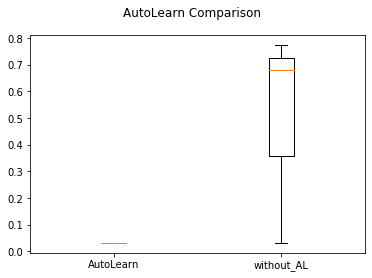

In [13]:
import matplotlib.pyplot as plt
label = ['AutoLearn', 'without_AL']
fig = plt.figure()
fig.suptitle('AutoLearn Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results_AL, positions=[1])
plt.boxplot(results_org, positions=[2])
ax.set_xticklabels(label)
plt.show()